# Graphs in bioinformatics
## Final project: Hierarchy in random graphs
### Statement of the problem

Consider an Erdős–Rényi (E-R) directed graph around the critical point of percolation. Before the critical point, there are many small strongly connected components. Exactly at the percolation point, the structure of the giant component in the E-R is tree-like. Finally, after the critical point, the giant component will _absorb_ all the small components.

Trees are highly hierarchical objects, thus is natural to ask if the E-R graph will show a peak for the appropriate hierarchical measures.

The following measures will be considered:
* the fraction of links not participating in any directed cycles,
* the Global Reaching Centrality introduced in E. Mones, L. Vicsek and T. Vicsek, [Hierarchy measure for complex networks.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0033799) PLoS ONE 7, e33799 (2012).

### The proposed solution to the problem

A numerical solution was implemented to inspect the appearance of a peak in the measures around the percolation limit. The following code used the [Networkx v2.4](https://networkx.github.io/documentation/stable/index.html) module for Python.
The script generates graphs and computes the hierarchical measures for graphs close to the percolation point. The estimations are made within a symmetric interval around the percolation point ($\langle k \rangle=1$).
The percolation point can be considered as a phase transition. The relative size of the giant component is zero for $\langle k \rangle<1$. For$\langle k \rangle\geq1$ it increases accordingly to the equation$S \approx 1 − e^{−\langle k\rangle S}$. For a directed E-R graph the average degree is $\langle k\rangle \approx Np$ (for large $𝑁$), considering $𝑁$ nodes in the graph and a probability $p$ of edge creation.

### Details of the numerical exploration
Parameters to control the numerical inspection.

* `N`nodes in the E-R graph.
* `p` probability of edge creation.
* `interval` is the size of the symmetric interval around the percolation point.
* `num_points` number of points to show in the graph.
* `sample_size` number of graphs to produce an ensemble of graphs.

The numerical exploration computed four attributes from any graph.

* Relative degree of the giant component.
* Fraction of edges not participating in any directed cycle.
* Average degree of the graph.
* Global reaching centrality.

These attributes were averaged over an ensemble of graphs. Each graph will have the same `N` and `p` values, this will reduce the fluctuations in the result due to the randomness of the E-R graph. To explore the surroundings of the percolation point we produce several ensembles to reconstruct the curve for each one of the measures.  For each one of the ensembles, `p` is modified keeping `N` constant.

In [10]:
#Import the necessary modules for the project.
import networkx as nx
import matplotlib.pyplot as plt
import csv
import statistics as stats
import math
from itertools import accumulate

Initialize the parameters and create 5 lists. These lists will be used to save the results of the numerical exploration.

In [11]:
rel_s = []
ed_no_cycle = []
mean_d = []
glo_cen = []
p_val = []
num_nodes = 1000
inv_nodes = 1/num_nodes
interval = 0.9
ini = inv_nodes-interval*inv_nodes
num_points = 35
fin = inv_nodes+interval*inv_nodes
sample_size = 70
interval = 0.9

Now it's time to create appropriate functions. The technicalities for each function are described within themselves.

In [12]:
def rel_size_giant(Gr):
    '''
    Parameters
    ----------
    Gr : A directed graph.

    Returns
    -------
    rel_giant_size : float
    Relative size of the largest strongly
    connected component
    '''
    num_n = Gr.number_of_nodes()
    #Uses Tarjan's algorithm to find 
    #the strongly connected components
    con_comp_it = nx.strongly_connected_components(Gr)
    largest = len(max(con_comp_it, key=len))
    rel_giant_size = largest/num_n
    return rel_giant_size

Find edges no participating in any cycle is equivalent to find bridges in the graph. Using the strongly connected decomposition we can isolate the nodes no participating in cycles, even more we can find the strongly connected components of the graph. Strongly connected components were found using [Tarjan's algorithm](https://en.wikipedia.org/wiki/Tarjan%27s_strongly_connected_components_algorithm). This algorithm has running time $O\left( |V|+|E| \right)$, considering that the expected number of edges for the E-R graph is $\binom{N}{2}p$; the running time can be estimated to be $O\left(|V|^2 \right)$.

In [13]:
def num_ed_no_cycle(Gr):
    '''
    Parameters
    ----------
    Gr : A directed graph.

    Returns
    -------
    ed_num_nocy : float
    Frequency of edges not participating
    in any cycle
    '''
    con_comp_it = nx.strongly_connected_components(Gr)
    num_edges = Gr.number_of_edges()
    con_edges = 0
    #Construct a subgraph for any connected component
    #Compute the number of edges in any connected component
    for h in con_comp_it:
        con_edges += Gr.subgraph(h).number_of_edges()
    #Frecueny of edges no participating in any cycle
    ed_num_nocy = (num_edges - con_edges)/num_edges
    return ed_num_nocy

To construct the local centrality is necessary a function to calculate the local reaching centrality. This function exploits the [Breadth-first search](https://en.wikipedia.org/wiki/Breadth-first_search) method implemented in Networkx module. This algorithm searches for all the reachable nodes in the graph from a starting node v. This method has a running time of $O\left(|V|^2 \right)$ in our particular graph. Then we loop through all the nodes in the graph to estimate the global reaching centrality. 

It is worth to mention that Networkx has a function that produces the same results as reported here. Looking in the source code of [networkx.algorithms.global_reaching_centrality](https://networkx.github.io/documentation/stable/_modules/networkx/algorithms/centrality/reaching.html#global_reaching_centrality) this method finds the shortest path from node any node v. Based on the [shortest path problem](https://en.wikipedia.org/wiki/Shortest_path_problem#Algorithms) the running time for solving this problem will be always bigger than $O\left(|V|^2 \right)$ for E-R graphs.

With the functions provided in this code, a faster computation can be achieved.

In [14]:
def local_centrality(Gr,v):
    '''
    Parameters
    ----------
    Gr : A directed graph.
    v : A root node to compute
    the local centrality measure

    Returns
    -------
    aux_loc_cen : float
    Local centrality measure
    '''
    num_n = Gr.number_of_nodes()
    #Use the Breath first-search to investigate
    #all the edges connected with node v
    edges = nx.bfs_edges(Gr, v)
    #Compute nodes from edges
    nodes = [v] + [k for u, k in edges]
    num_nodes = len(nodes)
    return num_nodes/num_n

def global_centrality(Gr):
    '''
    Parameters
    ----------
    Gr : A directed graph.

    Returns
    -------
    ax_glo_cent : float
    Global reaching centrality
    '''
    num_n = Gr.number_of_nodes()
    loc_cen_array = []
    #Compute the local centrality measure
    #for all the nodes in the graph
    for i in range(num_n):
        loc_cen_array.append(local_centrality(Gr, i))
    max_cen = max(loc_cen_array)
    uni_loc = [max_cen - k for k in loc_cen_array]
    return sum(uni_loc)/(num_n-1)

Create a nested loop to modify the probablity of links in the E-R graph. For each new value of p, we average over the ensemble and save the values. 

In [15]:
for i in [ini+i*((fin-ini)/num_points) for i in range(num_points+1)]:
    #Create auxiliary list to save the values of metrics
    #for all the graphs in the ensemble
    aux_mean_deg = []
    aux_rel_g_sz = []
    aux_glo = []
    aux_no_cyc = []
    for k in range(sample_size):
        #Creating all the graphs in ensemble for different values of p
        G = nx.erdos_renyi_graph(num_nodes, i, seed=None, directed=True)
        #########
        #Compute the mean degree for the graph
        deg = G.in_degree()
        flat_degree = [item[1] for item in deg]
        mean_degree = sum(flat_degree)/len(flat_degree)
        #########
        #Calling previously defined functions
        aux_rel_g_sz.append(rel_size_giant(G))
        aux_glo.append(global_centrality(G))
        aux_no_cyc.append(num_ed_no_cycle(G))
        aux_mean_deg.append(mean_degree)
    #Saving mean ensemble values for fixed value of p 
    rel_s.append(stats.mean(aux_rel_g_sz))
    ed_no_cycle.append(stats.mean(aux_no_cyc))
    glo_cen.append(stats.mean(aux_glo))
    mean_d.append(stats.mean(aux_mean_deg))
    p_val.append(i)
    
rows = zip(mean_d,rel_s,ed_no_cycle,glo_cen,p_val)
## Modify the string for saving to a file with a different file name
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in rows:
        writer.writerow(row)

Creating a graph to visualize the curves for each one of the hierarchical measures. The file to plot is the one created in the previous step. If you want to read from a file produced in another iteration just input the name in the next cell to import the file.

Value of p corresponding to maximum GRC: 1.33e-03


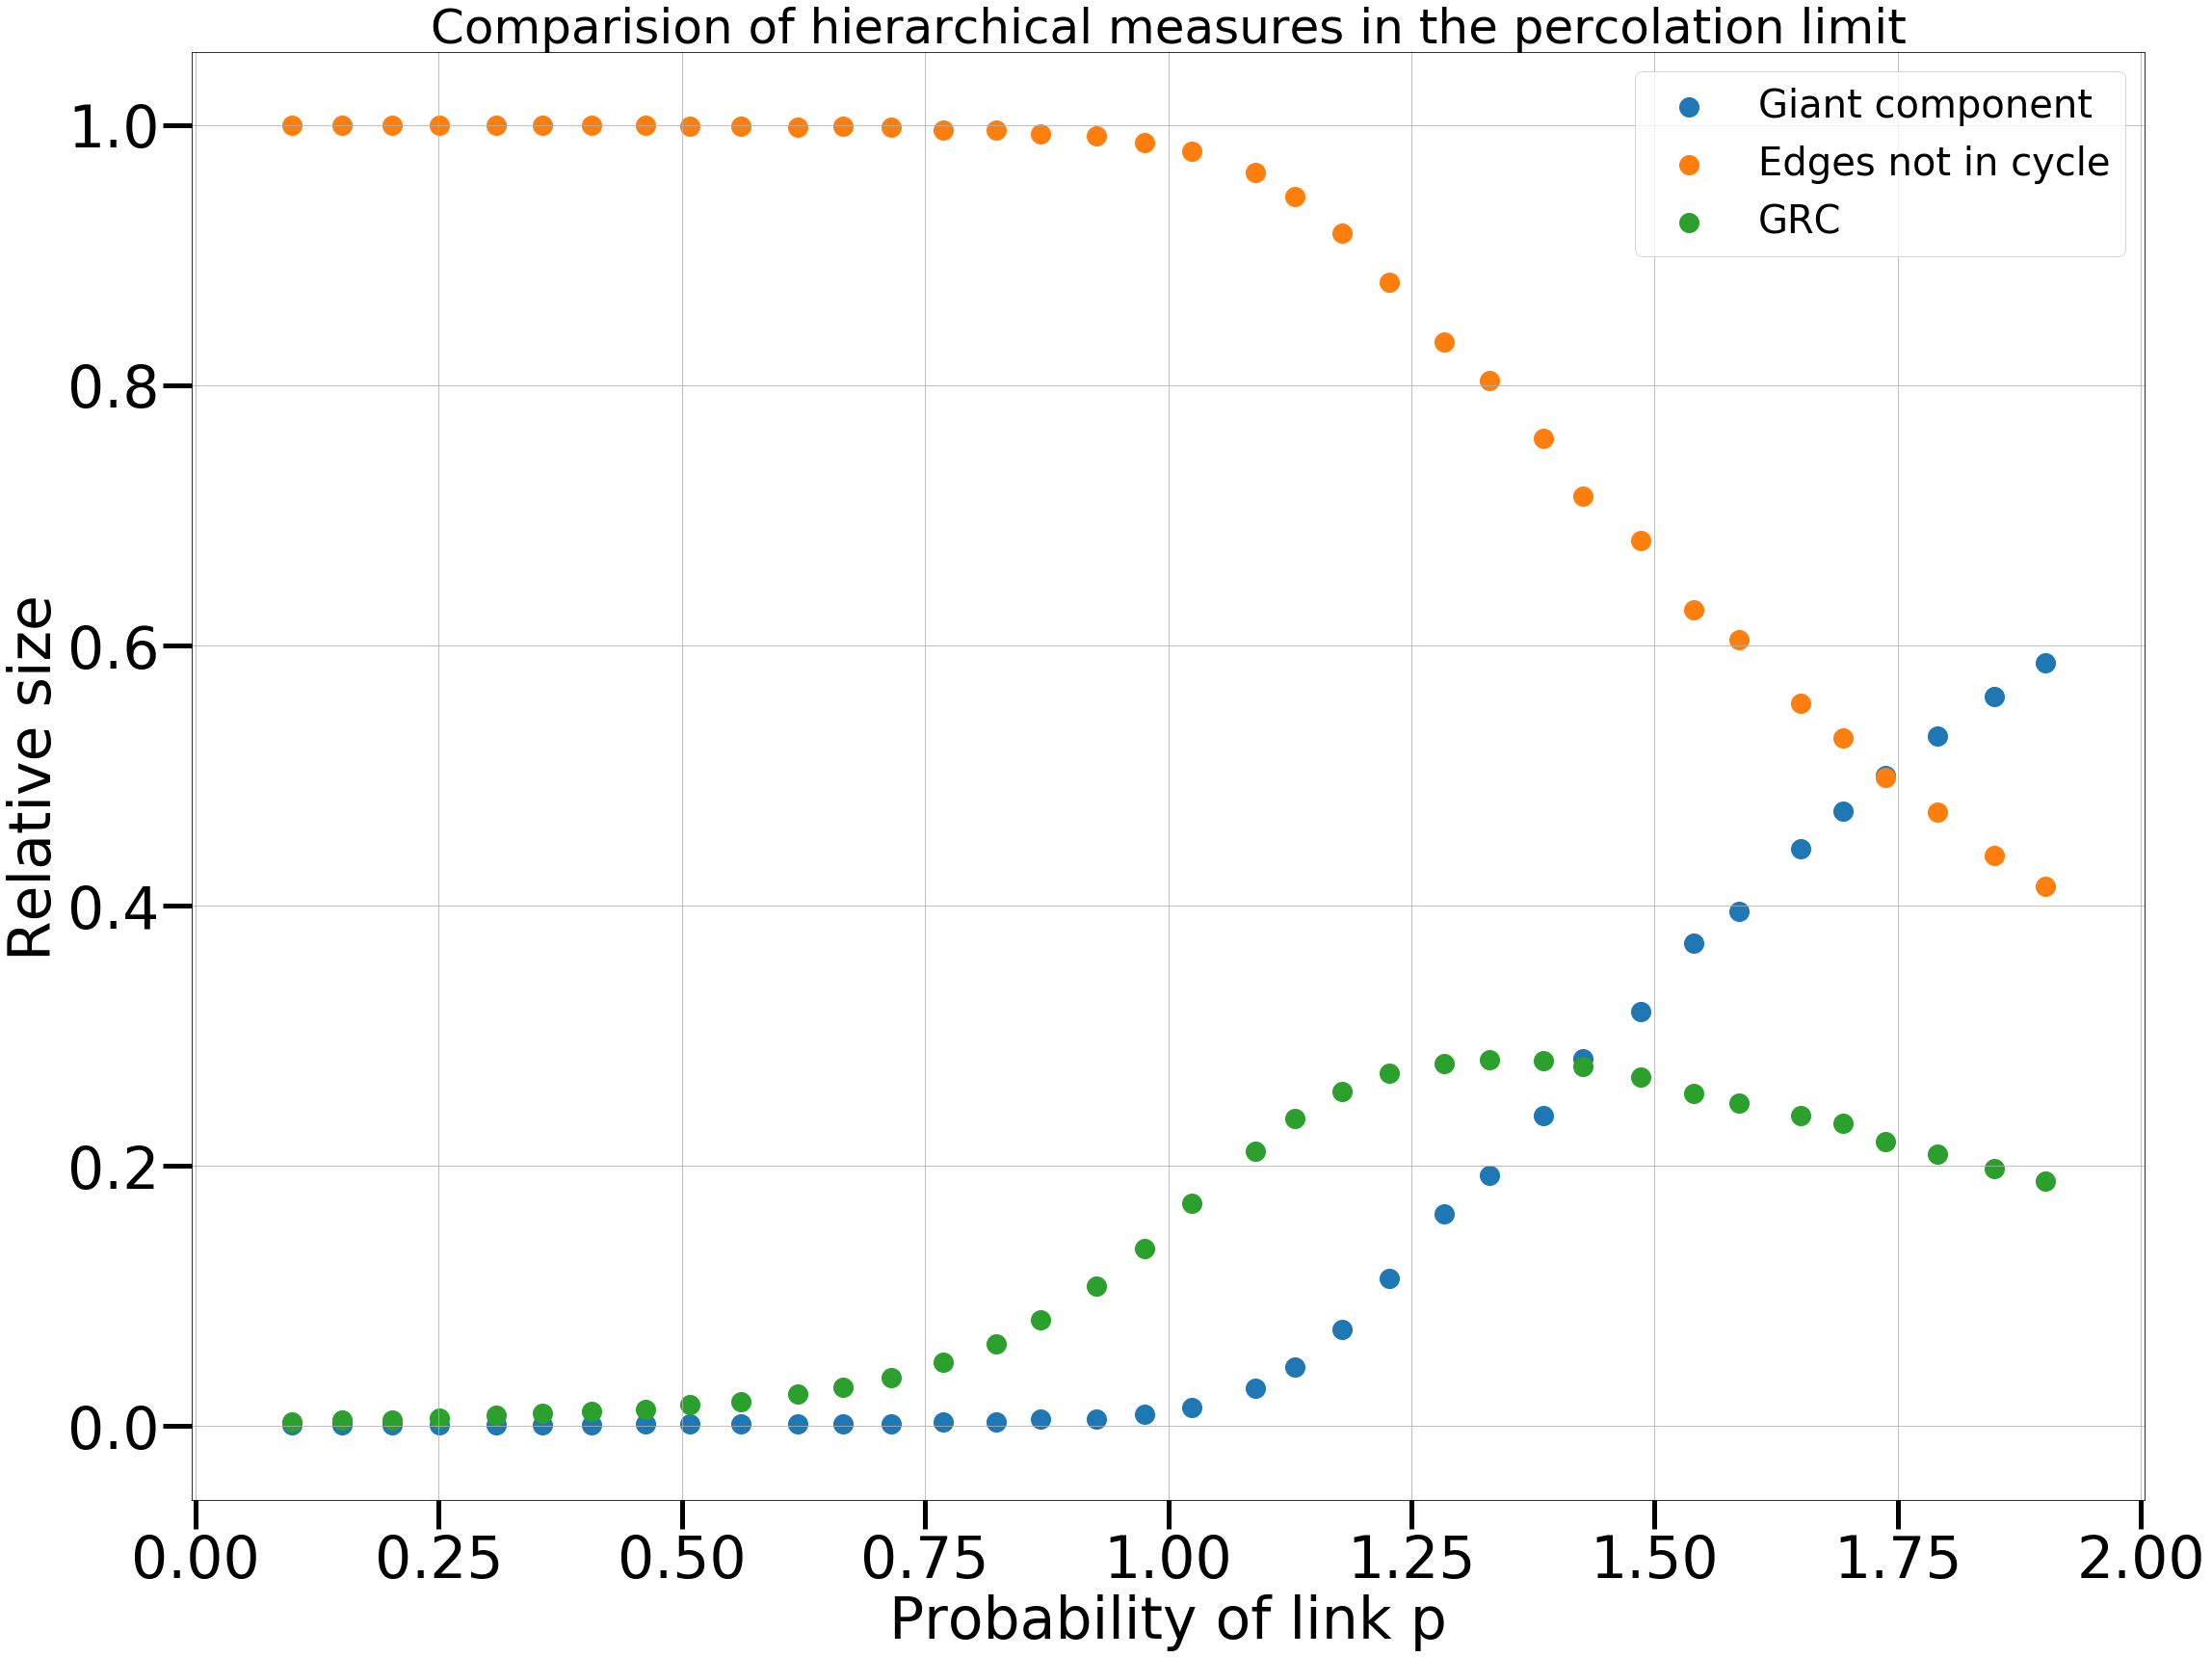

In [26]:
rel_s = []
ed_no_cycle = []
mean_d = []
glo_cen = []
p_val = []
##Modify the string to import from a different file name.
with open('test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    data = [[float(x) for x in row] for row in reader]
    
for item in data:
    mean_d.append(item[0])
    rel_s.append(item[1])
    ed_no_cycle.append(item[2]) 
    glo_cen.append(item[3])
    p_val.append(item[4])

#Extracting the value of p which corresponds to the maximum GRC.
max_glo_index, max_glo_value = max(enumerate(glo_cen), key=lambda p: p[1])
max_p_value = p_val[max_glo_index]
print('Value of p corresponding to maximum GRC: {:.2e}'.format(max_p_value))

fig,ax=plt.subplots(figsize=(32,24))
ax.set_title('Comparision of hierarchical measures in the percolation limit',fontsize=50)
ax.set_xlabel('Probability of link p',fontsize=60)
ax.set_ylabel('Relative size',fontsize=60)
ax.grid(True)
ax.tick_params(axis='both',labelsize=60,length=30,width=5)
ax.scatter(mean_d,rel_s,label = 'Giant component',s=400)
ax.scatter(mean_d,ed_no_cycle,label = 'Edges not in cycle',s=400)
ax.scatter(mean_d,glo_cen,label='GRC',s=400)
ax.legend(fontsize=40,markerscale=1)
fig.tight_layout()

In [17]:
def visual_graph(Gr,z_var):
    '''
    This function produces the visualization method described in the GRC article.
        Parameters
    ----------
    Gr : A directed graph.
    z : Parameter to compute the levels 
    in the hierarchy, the parameter needs
    to be small enough to differentiate all
    the levels
    
    Returns
    -------
    Print the graph
    '''
    node_l = list(Gr.nodes())
    #Compute the local reaching centrality of all the
    #nodes in the graph
    x_i = [local_centrality(Gr,v) for v in node_l]
    node_x_i = list(zip(node_l,x_i))
    node_x_i.sort(key=lambda p: p[1])
    sig_g = stats.stdev(x_i)
    dic_lev = {}
    dic_lev[0] = [node_x_i[0],node_x_i[1]]
    ##Create a dictionary to make all the levels
    #Each key of the dictionary will correspond 
    #to a level in the hierarchy
    for item in node_x_i:
        keys = list(dic_lev)
        last_lev = keys[-1]
        if len(dic_lev[last_lev]) < 2 :
            sig_l = 0
        else:
            sig_l = stats.stdev([x[1] for x in dic_lev[last_lev]])
        if sig_l < z_var*sig_g:
            dic_lev[last_lev].append(item)
        else:
            dic_lev[last_lev+1] = [item]
    levels = list(dic_lev)
    x_pos = {}
    y_dif = []
    ##Compute the mean difference in Y axis for all the levels
    ##We also create the position for the X axis
    #where the center of mass for each level is at position 0
    for level in levels:
        num_no = len(dic_lev[level])
        sym_ran = list(range(-2*math.floor(num_no/2),2*math.floor(num_no/2)+1,2))
        if num_no % 2 == 0:
            sym_ran.remove(0)
        x_pos[level] = sym_ran
        if level > 0:
            y_dif.append(stats.mean([x[1] for x in dic_lev[level]])
                         -stats.mean([x[1] for x in dic_lev[level-1]]))
    #From the mean difference we will calculate the difference between the 
    #levels in the graph
    min_y = min(y_dif)
    fin_y = [math.log((2*k)/min_y) for k in y_dif]
    fin_y.insert(0,0)
    fin_y = list(accumulate(fin_y))
    ##Create a list of tuples with the positions
    pos_tup = []
    for level in list(x_pos):
        level_list = [(node_it,fin_y[level]) for node_it in x_pos[level]]
        pos_tup.extend(level_list)
    #Creating a dictionary of nodes and postions for draw the graph
    node_sort = [k[0] for k in node_x_i]
    fig,ax=plt.subplots(figsize=(32,24))
    ax.set_title('Visualization of the hierarchy at the maximum of the GRC',fontsize=50)
    dic_draw = dict(zip(node_sort,pos_tup))
    print('Number of levels in the hierarchy: {}'.format(len(levels)))
    nx.draw_networkx(G,pos=dic_draw,arrowsize=25,with_labels=False)

Number of levels in the hierarchy: 61


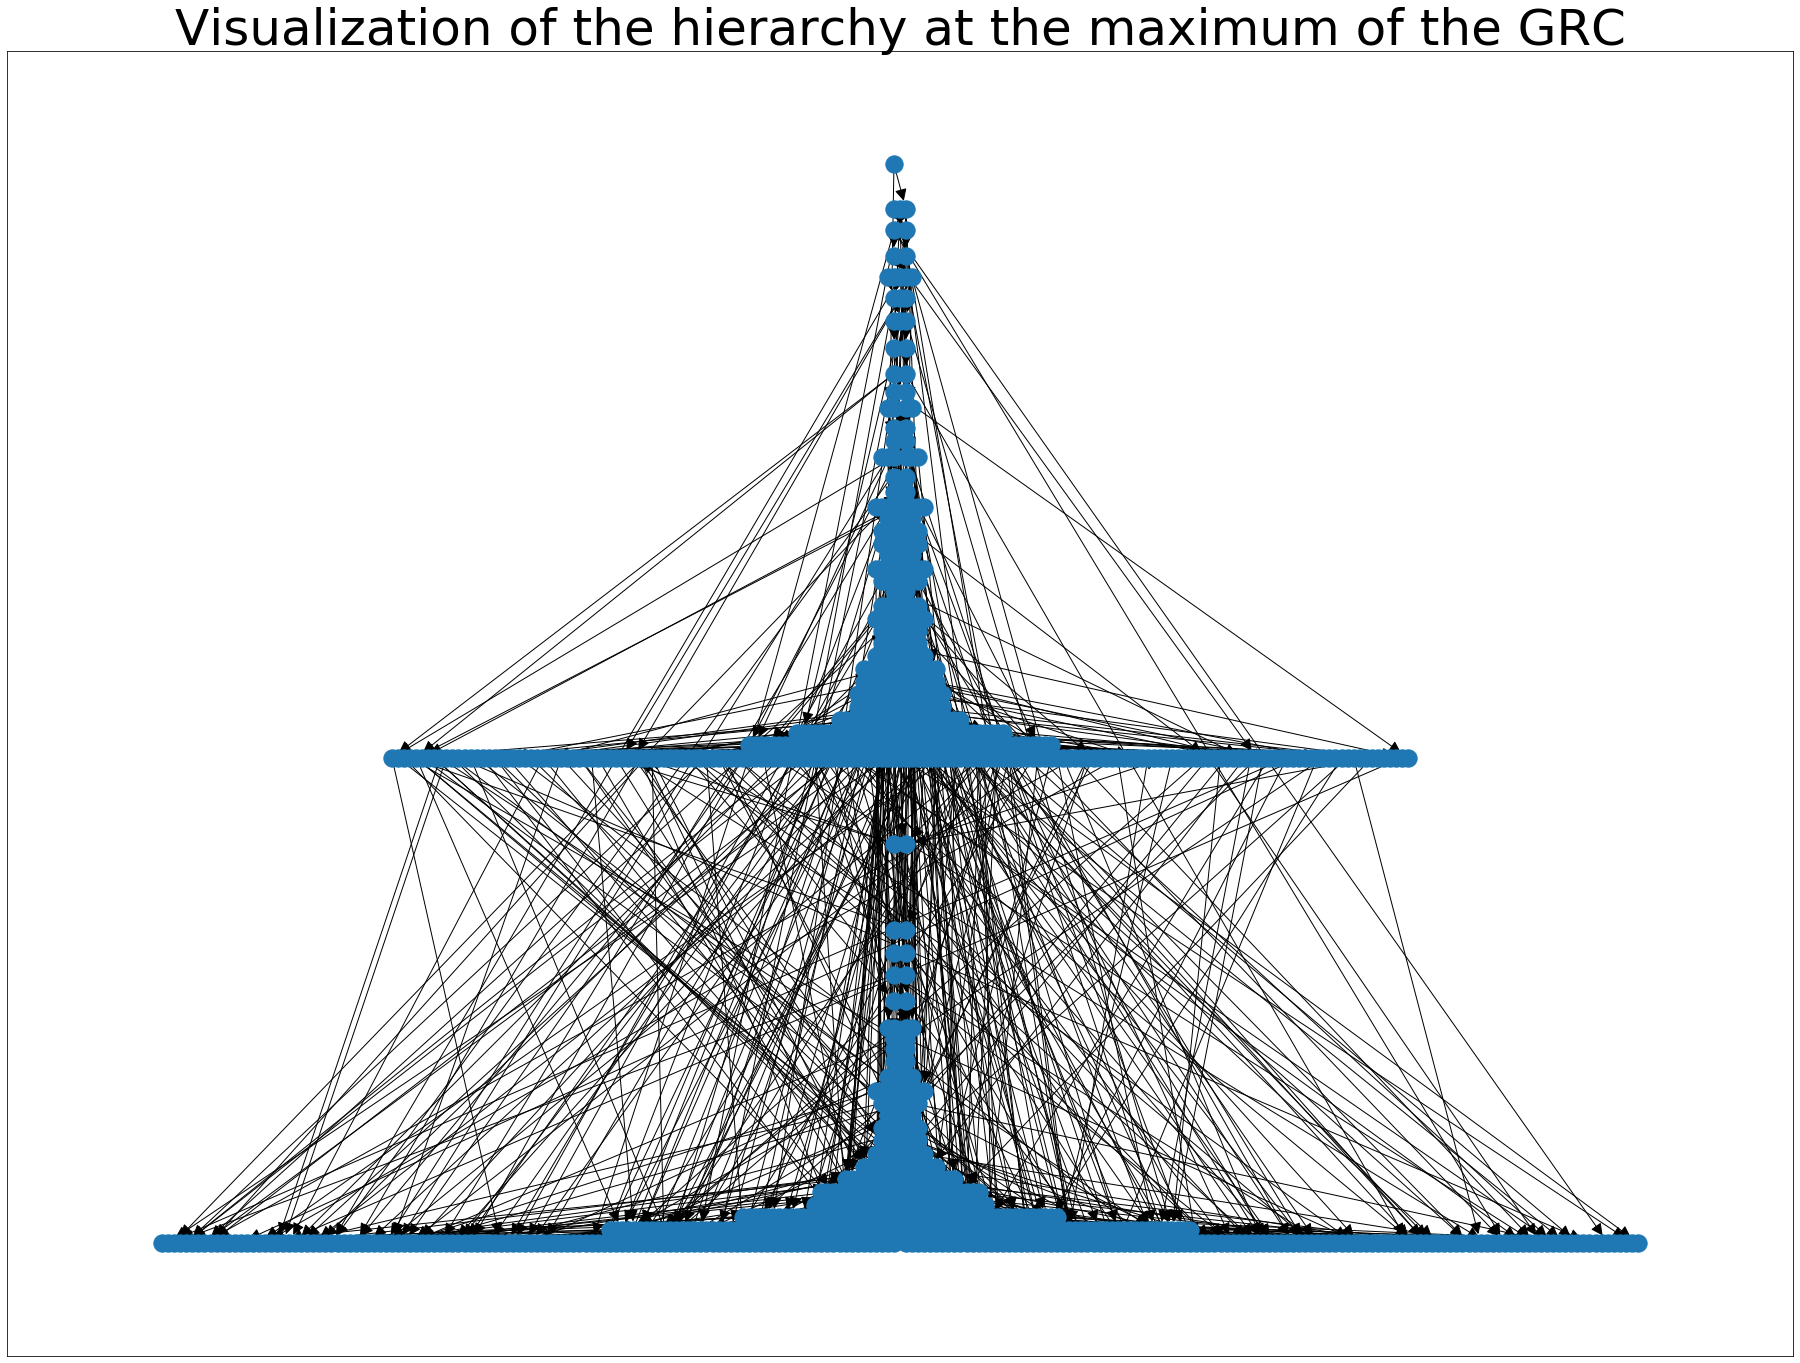

In [18]:
G = nx.erdos_renyi_graph(num_nodes, max_p_value, seed=None, directed=True)
visual_graph(G,0.0005)

### Discussion of the measures
* **The number of edges no participating in any cycle**.

When the link probability p is small an E-R graph is sparse, thus the formation of cycles is unlikely. As we get closer to the percolation limit, more edges start forming, but the hierarchy is not reflected in this measure. The only effect showed in the measure is a decrease in the number of edges no participating in any cycle due to the giant component. 

It is worth mention that this measure is a complementary quantity with respect to the relative size of the giant component. In other words, the sum of the number of edges no participating in any cycle and the relative size of the giant component sum up to one for any graph.

* **Global reaching centrality**.

The global reaching centrality shows a maximum close to the percolation limit, but not exactly at the critical point. One of the advantages provided by the GRC measure it's that it doesn't penalize for loops instead it describes the diversity of the local centrality. The local centrality is very homogeneous when the probability link is small because in an E-R graph all nodes have almost no links. On the contrary, when there is only one giant component almost every node is connected to all others, resulting in a homogeneous distribution of the reaching centrality. In a closer look to the GRC measure, it is clear that it starts increasing faster than the relative size of the giant component. Indicating that the creation of new links promotes the hierarchical organization before the appearance of the giant component
        
In conclusion, we discover that around the percolation point a hierarchical structure arises in the E-R directed graph. This hierarchical structure is unravelled by the GRC, in contrast to the other proposed measure which did not show any hint of where the most hierarchical structure is located.

There is still the mystery of why the maximum is not located exactly at $\langle x \rangle = 1$. In a previous discussion, it has been pointed out the GRC measure takes into account the distribution of reaching centrality. Thus the maximum doesn't need to be exactly at the percolation point. One can infer from the graph that it is the derivative of the GRC the curve that has a maximum very close to the percolation point. 